# Problem 4-3: Support Vector Machines **(4 pts total)**

## The aim of this lab assignment is to implement the Support Vector Machines (SVM) classification algorithm. We will discuss
* ###  the classical separating hyperplane (with hard margins)
* ###  separating hyperplane (with soft margins)
* ###  nonlinear separation (using kernels)  

## and understand how the respective opitmization problems (including the dual Wolfe problem) can be solved numerically.

## Good sources on SVM algorithms are

* ###  [Support Vector Mechines Succintly](https://www.syncfusion.com/succinctly-free-ebooks/support-vector-machines-succinctly) an introductory explanation of all related questions
* ###  [The Elements of Statistical Learning](https://hastie.su.domains/Papers/ESLII.pdf) an advanced treatment of the linear and non-linear SVM

### Prepared by **Yurii Yelisieiev**

## Completed by:
*   Roman Kovalchuk
*   Eduard Pekach



## 1. Preparation and Data Generation **(0.25 pt)**




### 1.1 Import packages

In [1]:
# Imports
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Fix configuration parameters

In [2]:
# Configuration options

blobs_random_seed = 42     #  change this!

centers = [(0,0), (5,5)]
cluster_std = 1
frac_test_split = 0.33
num_features_for_samples = 1
num_samples_total = 1000

### 1.3 Now we generate data, split for test/train datasets, and visualize the train dataset

The data are of the form $(\mathbf{x}_j,y_j)$, $j = 1,\dots, n$, where $\mathbf{x}_j \in \mathbb{R}^2$, and $y_j=1$ for red points and $y_j=-1$ for blue ones.

In [3]:
# Generate data
inputs, targets = make_blobs(n_samples = num_samples_total, centers = centers, n_features = num_features_for_samples, cluster_std = cluster_std)
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=frac_test_split, random_state=blobs_random_seed)
y_train = 2*y_train -1
y_test = 2*y_test-1

In [4]:
# separate blue and red points for convenience
red = X_train[np.where(y_train==1)]
blue = X_train[np.where(y_train==-1)]
# this is the direction vector to compare to
p = np.mean(red, axis = 0) - np.mean(blue, axis = 0)

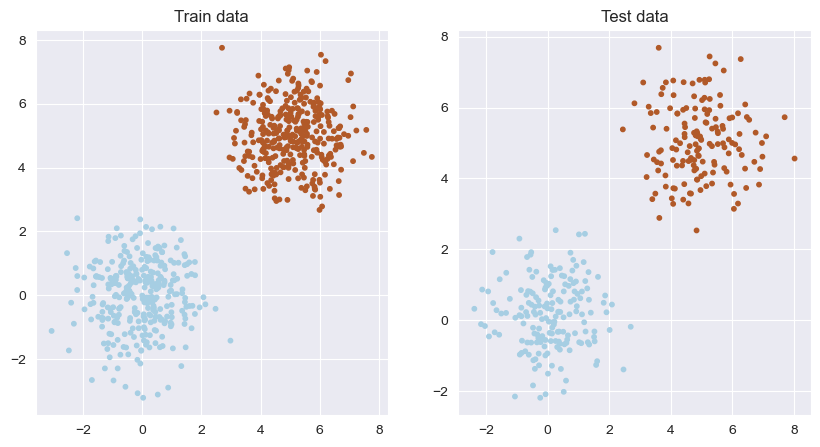

In [5]:
# Generate scatter plots for train and test data
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
plt.title("Train data")

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap=plt.cm.Paired)
plt.title("Test data")

plt.show()

### 1.4 Change the parameter `cluster_std` to 2 and regenerate the data.  

#### **Question 1.1 (0.25 pt)**  

*   What do you think that parameter is responsible for? What effect does it have on the data distribution?
---
This parameter is responsible for the variance and dispersion of generated clusters, the larger the parameter, the wider the clusters are spread from its mean; Therefore it could be harder to separate them, at the distributions might become less separable as parts of it overlay at each other. However sometimes it's a characteristic of real-world data, as it's not always linearly or very easy separable, especially at one dimension.

---




### 1.5 We will use the values `cluster_std = 1` and  `cluster_std = 2` for the hard and soft margin classifiers

**Remark**: Decrease 1 in `cluster_std = 1` if necessary to get separable sets; increase 2 in `cluster_std = 2` to get non-separable sets

### 1.6 Visualization function

This is the function to visualize the optimal hyperplane and the margin


In [6]:
#  decision function
def decision_funct(x, w, b):
  return np.dot(x, w) + b

#  visualization
def visualSVM(X, y, w, b, support):

  plt.scatter(X[:, 0], X[:, 1], c=y, s=10, alpha = .5, cmap=plt.cm.Paired)

# plot the decision function
  ax = plt.gca()
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

# create grid to evaluate model
  xx = np.linspace(xlim[0], xlim[1], 30)
  yy = np.linspace(ylim[0], ylim[1], 30)
  YY, XX = np.meshgrid(yy, xx)
  xy = np.vstack([XX.ravel(), YY.ravel()]).T
  Z = decision_funct(xy, w, b).reshape(XX.shape)

# plot decision boundary and margins
  ax.contour(
    XX, YY, Z, colors=['r', 'b', 'r'], levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
  )
# plot support vectors
  ax.scatter(
    X[support, 0],
    X[support, 1],
    s=50,
    linewidth=1,
    facecolors="none",
    edgecolors="g",
  )

We run the visualization with the normal vector $\mathbf{w} = [1, -0.2]$,  free term $b = -3$, and the vectors $\mathbf{x}_0$ and $\mathbf{x}_{100}$ encircled. The hyperplane is not separating; try several other values to see the effect.


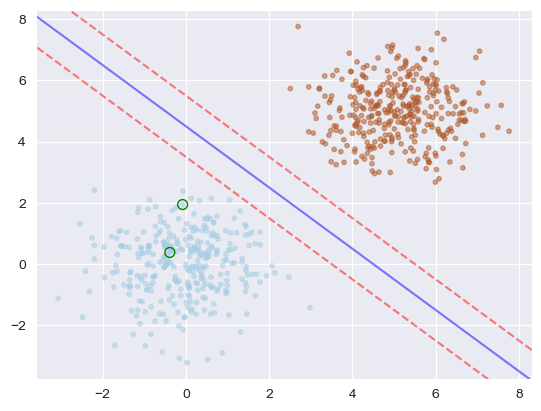

In [7]:
visualSVM(X_train, y_train, [1,1], -4.5, [0,100])


---
## 2. First task: Hard margin SVM classifier **(1 pt)** ##  

#### Given are the data $(\mathbf{x}_j,y_j)_{j=1}^n$ with $\mathbf{x}_j \in \mathbb{R}^2$ and $y_j = \pm 1$. The points $\mathbf{x}_j$ with $y_j=1$ are marked red and those with $y_j = -1$ blue. Under the assumption that red and blue points are linearly separable, the aim is to find the best ***linear classifier*** $f(\mathbf{x}) = \mathbf{x}\cdot\mathbf{w} + b$ such that $f(\mathbf{x})>0$ for red points and $f(\mathbf{x})<0$ for blue ones. We will determine $f$ using the training dataset and then evaluate its performance on the test dataset.
---




    

### 2.1: Choosing the optimal $b$ (0.25 pts)

For a given normal $\mathbf{w}\in\mathbb{R}^2$, find
*   the optimal position of the separating hyperplane $H : \mathbf{x}\cdot\mathbf{w} + b = 0$
*   calculate the margin (width)
*   rescale $\mathbf{w}$ and $b$ properly
*   visualize the separating hyperplane and the support vectors

The optimal separating hyperplane $$H:\quad \mathbf{x}\cdot\mathbf{w} + b = 0$$ with a fixed $\mathbf{w}$ is determined by $b = -(b_+ + b_-)/2$, where
$$b_+ = \min_{j:y_j = 1} \, (\mathbf{x}_j\cdot\mathbf{w}) \qquad \text{and} \qquad b_- = \max_{j:y_j = -1}\, (\mathbf{x}_j\cdot\mathbf{w})$$
and the margin (half-)width is
$$ d = \text{(missing formula)} $$

**Remarks:**
*   Observe that the direction of the normal vector $\mathbf{w}$ should be chosen so that $\mathbf{p}\cdot \mathbf{w}>0$, where $\mathbf{p}$ is the vector connecting the centroids of the blue ($y_j = -1$) and red ($y_j = 1$) points; this guarantees that $b_+ > b_-$ for _optimal separating_ hyperplanes. However, the inequality $b_+ > b_-$ is not guaranteed even if $\mathbf{p}\cdot \mathbf{w}>0$; you should take this into account during scaling
*   After calculating $d$ for properly oriented $\mathbf{w}$, rescale $\mathbf{w}$ and $b$ so that $f(\mathbf{x}) = \pm1$ for support vectors



#### **Question 2.1.1 (0.25 pt)**  

*   Write down the formula for $d$ and fill in the missing lines in the code below
---
The half-width of the margin, denoted as $d$, is calculated as half the difference between the minimum positive dot product ($b_+$) and the maximum negative dot product ($b_-$) with the separating hyperplane:

$$d = \frac{b_+ - b_-}{2}$$

---


In [8]:
import numpy as np

def optimal_b(w):
    # input:   w is the normal vector of the hyperplane
    # output:  (half-)width d, properly scaled w; properly scaled b; support points (vectors) indices

    # check if w is properly oriented
    if np.dot(w,p) < 0:
        w = np.multiply(w, -1)

    # calculate b_red and the corresponding support vectors
    b_red = np.min(np.dot(red, w))
    # these are indices of the red support vectors; we allowed tolerance 0.01
    sprt_red = np.where(abs(np.dot(X_train, w) - b_red) < 0.01)[0]

    # calculate b_blue and the corresponding support vectors
    b_blue = np.max(np.dot(blue, w))  # Fix: changed np.min to np.max
    sprt_blue = np.where(abs(np.dot(X_train, w) - b_blue) < 0.01)[0]

    # concatenate the lists
    sprt = np.concatenate((sprt_red, sprt_blue))

    # calculate the actual width of the separating slab
    d = (b_blue - b_red) / 2  # Calculate half-width

    b = -(b_red + b_blue) / 2  # Calculate bias

    # the proper scaling factor for w and b
    sc_fact = np.linalg.norm(w)

    w = w / sc_fact   # rescale w
    b = b / sc_fact  # rescale b

    return d, w, b, sprt


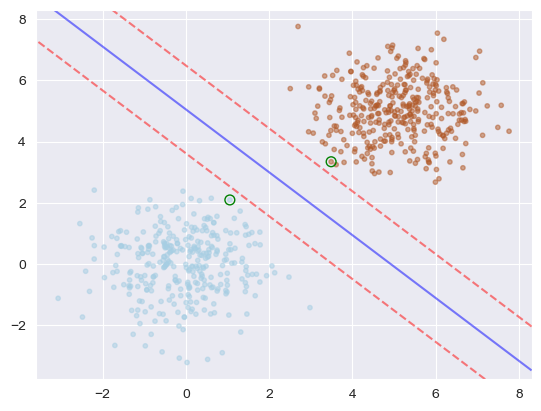

In [9]:
### Test the performance of the function by choosing w = p
_, w, b, sprt = optimal_b(p)
visualSVM(X_train, y_train, w, b, sprt)

### 2.2: Direct maximization of the margin **(0.25 pt)**

Maximize the margin over the directions of $\mathbf{w} = (\cos\phi, \sin\phi)^\top$, find the best separating hyperplane and evaluate its performance on the test dataset


Run through all directions $\phi \in [0,\pi)$ and
*   find the optimal direction of the separating hyperplane
*   the optimal position (parameter $b$) of the separating hyperplane $H : \mathbf{x}\cdot\mathbf{w} + b = 0$
*   visualize the separating hyperplane and the support vectors
*   calculate the margin (width)


---
#### **Question 2.2.1 (0.25 pt)**  

*   Fill in the missing parts of code in the listing below
---

In [10]:
import numpy as np

d = -1000
n = 1000
phi_opt = 0
opt = ()
for i in range(n):
    phi = i * np.pi / n
    w = [np.cos(phi), np.sin(phi)]

    # Call the function to get margin, scaled w and b, and support vectors
    d_curr, w_curr, b_curr, sprt_curr = optimal_b(w)

    # Compare the current margin with the maximum and update if necessary
    if d_curr > d:
        d = d_curr
        phi_opt = phi
        opt = (d_curr, w_curr, b_curr, sprt_curr)

print("The margin is:", opt[0], "\toptimal w is:", opt[1], "\toptimal b is:", opt[2])
d_opt, w_opt, b_opt, sprt = opt

The margin is: 3.385304952426062 	optimal w is: [ 0.69816542 -0.71593648] 	optimal b is: 0.28633880930624134


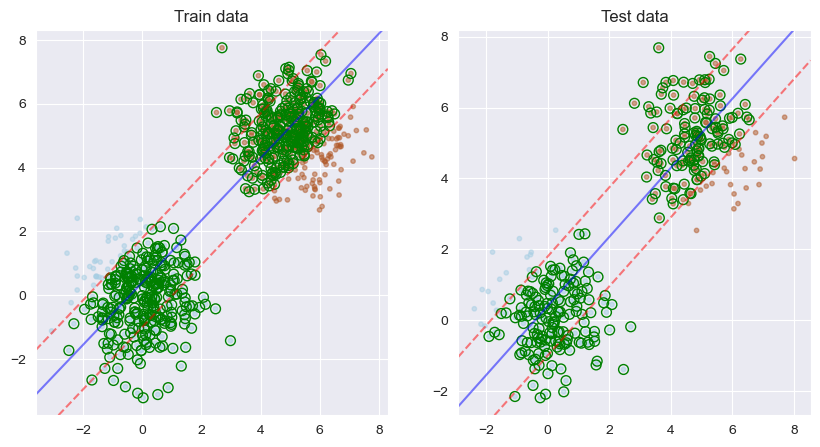

In [11]:
# illustrate decision for train and test data
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
sprt = np.where(y_train * decision_funct(X_train, w_opt, b_opt) < 1.01)[0]
visualSVM(X_train, y_train, w_opt, b_opt, sprt)
plt.title("Train data")

plt.subplot(1, 2, 2)
sprt = np.where(y_test * decision_funct(X_test, w_opt, b_opt) < 1.01)[0]
visualSVM(X_test, y_test, w_opt, b_opt, sprt)
plt.title("Test data")

plt.show()

#### Evaluate the optimal classifier on the test set:




In [12]:
def misclassified(X, y, w, b):
    decision_values = np.dot(X, w) + b
    predictions = np.sign(decision_values)
    misclassified_indices = np.where(predictions != y)[0]
    return misclassified_indices

# calculate the fraction of the test points that are misclassified
len(misclassified(X_test, y_test, w_opt, b_opt))/len(X_test)

0.5181818181818182

### 2.3 SVM as an optimization problem and dual Wolfe problem **(0.5 pts)**


#### 2.3.1 Optimization problem
Let $f(\mathbf{x}) = \mathbf{x}\cdot \mathbf{w} + b$ be a linear classifier predicting the response variable $y$ via
$$
  y = \operatorname{sign}(f(\mathbf{x}))
$$

The task is to maximize the margin, i.e., the value $M$ s.t., for all $j$,
$$
   y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge M \|\mathbf{w}\|
$$
By rescaling $\mathbf{w}$ (and $b$) so that $M\cdot\|\mathbf{w}\| = 1$, we get an equivalent problem
\begin{align}
\operatorname{argmin}_{\mathbf{w}, b}  &\frac12 \|\mathbf{w}\|^2 \\
\text{subject to } \qquad &y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge 1
\end{align}

The Lagrange function is
$$
  \mathscr{L}(\mathbf{w}, b, \lambda) = \frac12\|\mathbf{w}\|^2 + \sum_j \lambda_j  [1 - y_j(\mathbf{x}_j\cdot \mathbf{w} + b)]
$$
Partial derivatives in $\mathbf{w}$ and $b$ give the equalities
$$
    \mathbf{w} = \sum_j \lambda_j y_j \mathbf{x}_j \qquad \text{and} \qquad 0 = \sum_j \lambda_j y_j; \tag{1}
$$
and the slackness conditions (3) below for every $j$.

We now use these expressions in $\mathscr{L}$ to get the Wolfe dual problem of maximizing the quadratic problem
\begin{equation}
   \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, \mathbf{x}_j\cdot\mathbf{x}_k \tag{2}
\end{equation}
subject to the constraints $\lambda_j \ge 0$ and the slackness conditions that should be satisfied for every $j$:  
$$
   \lambda_j [1 - y_j(\mathbf{x}_j\cdot \mathbf{w} + b)] = 0 \tag{3}
$$
Indices $j$ for which $y_j(\mathbf{x}_j\cdot \mathbf{w} + b) = 1$ correspond to *support vectors* (i.e., points on the margin boundary).

#### 2.3.2 Sequential Minimal Optimization
The Wolfe dual problem can be solved by applying the so called Sequential Minimal Optimization (SMO) method. The idea is to update only two (randomly chosen) Lagrange multipliers a time, say $\lambda_i$ and $\lambda_j$, in such a way that the constraint condition $\sum_k \lambda_ky_k = 0$ is preserved, the updated lambda's are non-negative, and the value of the function increases.

To this end, we calculate the partial derivatives of $\mathscr{L}$ in $\lambda_i$ and $\lambda_j$, form the partial gradient $\mathbf{g}_{i,j}$, and move along the constraint line $\ell = \lambda_i y_i + \lambda_j y_j = \mathrm{const}$ to increase the value of $\mathscr{L}_D$. If the direction vector $\mathbf{d}:=(y_j, -y_i)$ of $\ell$ forms an acute angle with $\mathbf{g}_{i,j}$, we update the two lambda's in that direction; otherwise, in the opposite. The simplest implementation uses a constant learning rate, but you may try the _exact line search_

---
#### **Question 2.3.1 (0.25 pts)**  

*   Fill in the missing parts of code in the listings below
---

In [13]:
# calculate the partial derivative in lambda_j and fill in the missing line
def partial_derivative(X, y, lmbda, j):
    sumX = np.sum([lmbda[i] * y[i] * X[i] for i in range(len(X))], axis=0)  # Sum over all data points
    return 1 - y[j] * np.dot(X[j], sumX)

In [14]:
# complete the update rule for lambda_i and lambda_j
def dualSVM_SMO(X, y):
    lmbda = np.array([0.0 for i in range(len(X))])
    lr = 0.001
    for k in range(10000):
        i, j = np.random.randint(0, len(X), size=2)

        if y[j] * partial_derivative(X, y, lmbda, i) - y[i] * partial_derivative(X, y, lmbda, j) > 0:
            ### moving along the direction vector (y_j, -y_i)
            ### calculate the possible step size:
            step_in_i = lr if y[j] > 0 else lmbda[i]
            step_in_j = lr if y[i] < 0 else lmbda[j]
            step = min(step_in_i, step_in_j, lr)

            lmbda[i] += step * y[i]
            lmbda[j] -= step * y[j]

        elif y[j] * partial_derivative(X, y, lmbda, i) - y[i] * partial_derivative(X, y, lmbda, j) < 0:
            ### move along the opposite direction
            step_in_i = lr if y[j] > 0 else lmbda[i]
            step_in_j = lr if y[i] < 0 else lmbda[j]
            step = min(step_in_i, step_in_j, lr)

            lmbda[i] -= step * y[i]
            lmbda[j] += step * y[j]

    print("no. of steps:", k, "no of positive lambdas:", len(lmbda[lmbda > 0]))
    return lmbda

lmbda = dualSVM_SMO(X_train, y_train)

lmbda = dualSVM_SMO(X_train,y_train)

no. of steps: 9999 no of positive lambdas: 443
no. of steps: 9999 no of positive lambdas: 414


In [15]:
#  calculate the direction vector w from equation (1) in part 2.4.1.
# Calculate the direction vector w from equation (1)
w = np.sum([lmbda[i] * y_train[i] * X_train[i] for i in range(len(X_train))], axis=0)

# Normalize w
w /= np.linalg.norm(w)

# Calculate other parameters using the optimal_b function
d, w_smo, b_smo, sprt = optimal_b(w)

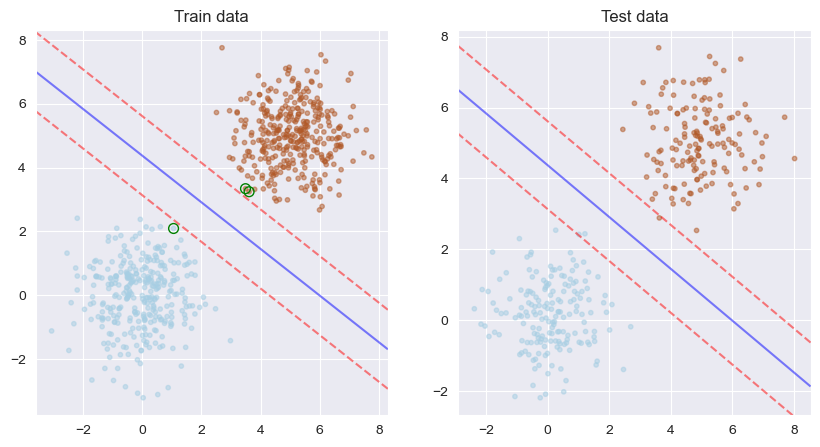

In [16]:
# illustrate decision for train and test data
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
idx = np.where(y_train * decision_funct(X_train, w_smo, b_smo) < 0)[0]
visualSVM(X_train, y_train, w_smo, b_smo, sprt)
plt.title("Train data")

plt.subplot(1, 2, 2)
idx = np.where(y_test * decision_funct(X_test, w_smo, b_smo) < 0)[0]
visualSVM(X_test, y_test, w_smo, b_smo, idx)
plt.title("Test data")

plt.show()

In [17]:
# calculate the fraction of the test points that are misclassified
len(misclassified(X_test, y_test, w_smo, b_smo))/len(X_test)

0.0

#### **Question 2.3.2 (0.25 pt): Wolfe duality summary**

Summarize in a few sequences how the dual Wolfe problem is used to find the optimal separation hyperplane and how it is solved using the SMO method

---
The dual Wolfe problem formulates the task of finding the optimal separation hyperplane in SVMs by maximizing the margin while adhering to certain constraints. The SMO algorithm iteratively updates Lagrange multipliers:
1. It selects pairs violating optimality conditions.
2. Progressing towards the optimal solution, it determines the direction vector of the hyperplane using support vectors and their corresponding non-zero Lagrange multipliers.
3. This enables the computation of bias and margin parameters for the hyperplane.
---


## 3. Second task: Soft margin SVM classifier **(0.75 pt)**

For the purpose of this last part, create overlapping red and blue blobs with `cluster_std = 2`

In [18]:
# Generate overlapping data
cluster_std = 2

inputs, targets = make_blobs(n_samples = num_samples_total, centers = centers, n_features = num_features_for_samples, cluster_std = cluster_std)
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=frac_test_split, random_state=blobs_random_seed)
y_train = 2*y_train -1
y_test = 2*y_test-1
# separate blue and red points for convenience
red = X_train[np.where(y_train==1)]
blue = X_train[np.where(y_train==-1)]
# this is the direction vector to compare to
p = np.mean(red, axis = 0) - np.mean(blue, axis = 0)

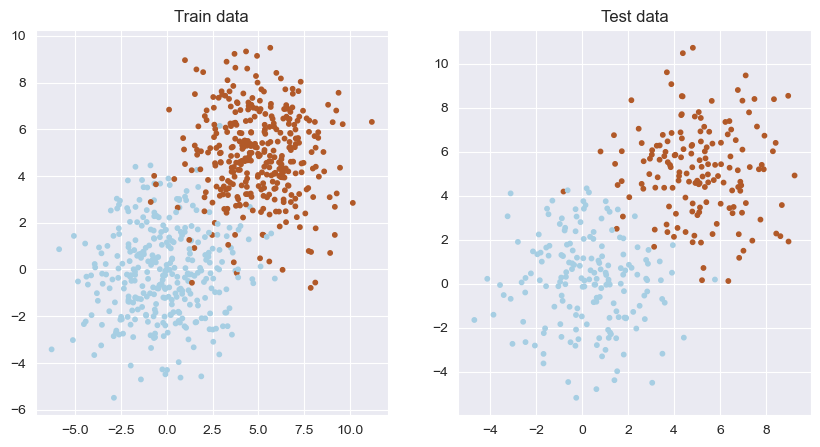

In [19]:
# Generate scatter plots for train and test data
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
plt.title("Train data")

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap=plt.cm.Paired)
plt.title("Test data")

plt.show()

### 3.1 Slack variables and the objective function

In most situations, the classes are not linearly separable, i.e., there is no hyperplane separating red and blue points in $\mathbb{R}^n$ (cf. the simulated dataset with `cluster_std = 2`). In that case, we must accept that some training points will not be properly classified but try to keep their number low. Also, it is desirable to have a ''separating'' hyperplane with a relatively large margin ensuring robustness to noise. Thus our aim is to find a hyperplane $H$ and a margin $M = 1/\|\mathbf{w}\|$ such that almost all training observations are properly classified and are outside the slab of width $M$ aroung the hyperplane $H$ and the misclassification penalty is low.

To this end, we introduce the slack variables $\xi_j\ge0$ and impose relaxed  constraints
$$
  y_j[\mathbf{x}_j\cdot \mathbf{w} + b] \ge 1 - \xi_j. \tag{2}
$$
The slack variables
$$
  \xi_j = \max\{0, 1- y_j[\mathbf{x}_j \cdot \mathbf{w} + b]\}
$$
measure incorrectness of classification: $\xi_j = 0$ for correctly classified points outside the slab and $\xi_j >0$ for points that fall inside the slab or are in the wrong halfspace. The new objective function is
$$
  f(\mathbf{w},b,\xi_j) = \frac12\|\mathbf{w}\|^2 + C \sum_j \xi_j
$$
under the constraints (2); here $C$ is the cost constant penalizing misclassification.


#### **Question 3.1.1 (0.25 pt): Constant $C$ effect**

Explain the effect that small and large cost constants $C$ should have on the solution

---

Small values of the cost constant $C$ will lead to a model that prioritizes maximizing the margin (minimizing $|\mathbf{w}|^2$) while allowing more misclassifications (higher $\xi_j$ values). With small $C$, the model focuses more on finding a hyperplane with a larger margin even if it means misclassifying some training points.

On the other hand, large values of $C$ will lead to a model that prioritizes minimizing misclassifications (minimizing $\sum_j \xi_j$) even if it means having a smaller margin. With large $C$, the model places more emphasis on correctly classifying all training points, potentially sacrificing margin size in the process.

---

### 3.2 Gradient descent **(0.75 pt)**

We rewrite the objective function as follows:
$$
    g(\mathbf{w},b) = \frac12 \|\mathbf{w}\|^2 + C \sum_{\xi_j>0}(1- y_j[\mathbf{x}_j \cdot \mathbf{w} + b])
$$
and apply the gradient descent method. The gradient is
\begin{align}
  \nabla_{\mathbf{w}} g & = \text{(mising formula)} \\
  \frac{\partial g}{\partial b} &= \text{(missing formula)}
\end{align}
and the method updates the variables,
$$
  (\mathbf{w}_{n+1}, b_{n+1})^\top = (\mathbf{w}_{n}, b_{n})^\top - \alpha \nabla g(\mathbf{w}_{n}, b_{n})
$$
until the stopping criterion is met.


#### **Question 3.2.1 (0.25 pts): Gradient calculation**

Calculate the gradient and plug in the formula below:

---
To calculate the gradient of the objective function $g(\mathbf{w}, b)$ with respect to $\mathbf{w}$ and $b$, we need to find the partial derivatives:

\begin{align}
  \frac{\partial g}{\partial \mathbf{w}} &= \mathbf{w} - C \sum_{\xi_j > 0} y_j \mathbf{x}_j \\
  \frac{\partial g}{\partial b} &= -C \sum_{\xi_j > 0} y_j
\end{align}

Explanation:
- For $\frac{\partial g}{\partial \mathbf{w}}$, the first term is simply $\mathbf{w}$, as it comes from the regularization term. The second term is the contribution from the misclassified points, where we sum over all misclassified points (i.e., where $\xi_j > 0$) and adjust $\mathbf{w}$ by $C$ times the misclassification error ($\sum_{\xi_j > 0} y_j \mathbf{x}_j$).
- For $\frac{\partial g}{\partial b}$, the term is simply $-C$ times the sum of the labels of the misclassified points. Since each misclassified point contributes $1 - y_j(\mathbf{x}_j \cdot \mathbf{w} + b)$ to $g$, the derivative with respect to $b$ is simply $-C$ times the sum of the labels of the misclassified points.

These derivatives provide the direction in which the objective function increases most rapidly, allowing us to update the parameters $\mathbf{w}$ and $b$ using gradient descent.

---




---
#### **Question 3.2.2 (0.125 pts)**  

*   Fill in the missing parts of code in the listings below
---

In [20]:
### objective function: fill in missing part (1 pt)
def g(X, y, w, b, C):
    idx = np.where(y * decision_funct(X, w, b) < 1)[0]

    # Regularization term
    reg_term = 0.5 * np.dot(w, w)

    # Misclassification penalty term
    penalty_term = C * np.sum(1 - y[idx] * (np.dot(X[idx], w) + b))

    result = reg_term + penalty_term

    return result


In [21]:
def grad_g(X, y, w, b, C):
    idx = np.where(y * decision_funct(X, w, b) < 1)[0]

    # regularization term
    grad_reg_w = w

    #misclassification penalty term
    grad_pen_w = -C * np.sum(y[idx][:, np.newaxis] * X[idx], axis=0)
    grad_pen_b = -C * np.sum(y[idx])

    grad_gw = grad_reg_w + grad_pen_w
    grad_gb = grad_pen_b

    return grad_gw, grad_gb


In [22]:
### iteration: fill in missing part (1 pt)
epsilon = 0.0001 # tolerance

def grad_desc_svm(X, y, C):
    w = np.zeros(2)
    b = 0
    incr = 1
    step = 0
    g_cur = g(X, y, w, b, C)

    while incr > epsilon and step < 10000:
        step += 1
        if step % 100 == 0:
            print("step = ", step, "\tfunction", g(X, y, w, b, C), "\tw=", w, "\tb = ", b, "\tlast decrease =", incr)

        grad_w, grad_b = grad_g(X, y, w, b, C)  # Gradient
        alpha = 0.001  # Initial learning rate

        while alpha > 1e-6:
            w_upd = w - alpha * grad_w  # Update w
            b_upd = b - alpha * grad_b  # Update b
            if g(X, y, w_upd, b_upd, C) < g_cur:
                w = w_upd
                b = b_upd
                incr = g_cur - g(X, y, w, b, C)
                g_cur = g(X, y, w, b, C)
                break
            else:
                alpha = alpha / 2  # Halve the learning rate if no improvement

    print(step)
    return w, b


In [23]:
### run the gradient descent

w, b = grad_desc_svm(X_train, y_train, 0.5)

step =  100 	function 37.53188795234875 	w= [0.43672335 0.48687542] 	b =  -2.1589999999999994 	last decrease = 0.040003332394284996
step =  200 	function 35.7182405906654 	w= [0.50703362 0.55602836] 	b =  -2.5557500000000006 	last decrease = 0.007763761026936322
step =  300 	function 35.053651555087654 	w= [0.53135542 0.61450228] 	b =  -2.799499999999994 	last decrease = 0.004566502438791531
step =  400 	function 34.690735715647314 	w= [0.56069147 0.66048154] 	b =  -2.98024999999999 	last decrease = 0.0028818472820759666
458


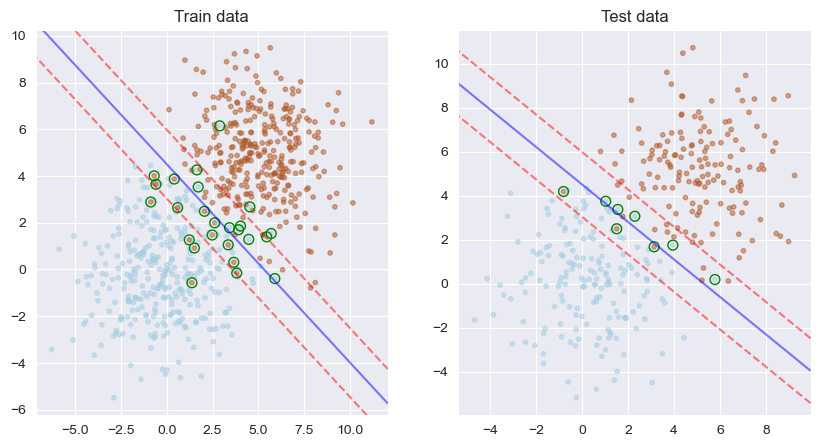

In [24]:
# illustrate decision for train and test data
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
idx = np.where(y_train * decision_funct(X_train, w, b) < 0)[0]
visualSVM(X_train, y_train, w, b, idx)
plt.title("Train data")

plt.subplot(1, 2, 2)
idx = np.where(y_test * decision_funct(X_test, w, b) < 0)[0]
visualSVM(X_test, y_test, w, b, idx)
plt.title("Test data")

plt.show()

In [25]:
### test the classifier (1 pt)
print("Model accuracy:", 1 - len(misclassified(X_test, y_test, w, b))/len(X_test))

Model accuracy: 0.9757575757575757


#### **Question 3.4 (0.125 pt): SVM via gradient descent summary**

Summarize in a few sequences how the optimal separating hyperplane can be found in non-separated case. Comment on the gradient descent method and its convergence. How does C affect the model?

---
To find the optimal separating hyperplane in a non-separated case:
1. Introduce slack variables $\xi_j$ to allow for misclassifications.
2. Formulate the objective function combining a regularization term and a misclassification penalty term.
3. Utilize gradient descent to minimize the objective function, updating parameters iteratively until convergence.
4. Assess the model's accuracy during training to gauge its performance.

Gradient descent iteratively updates parameters to minimize the objective function, with the learning rate $\alpha$ determining step size.

The cost constant $C$ influences the trade-off between margin size and misclassification rate, affecting the model's robustness and generalization ability.

---


## 4. Third task: nonlinear SVM **(1 pt)**

In this part, we'll implement the simplest version of the non-linear SVM, namely the one with the so-called polynomial kernel.



### 4.1 The main idea

In the case when the data are not linearly separable, we can try a nonlinear classifier function $f(\mathbf{x})$. For instance, if the red points are above the parabola $x_2 = x_1^2$ and all blue points are below it, then a natural candidate for the classifier is $f(\mathbf{x}) = -x_1^2 + x_2$.

For instance, with every $\mathbf{x} = (x_1,x_2)^\top$, we can consider the $6$-tuple
$$
   \phi(\mathbf{x}) = (1, \sqrt2x_1, \sqrt2x_2, x_1^2, x_2^2, \sqrt2x_1x_2)^\top
$$
and the classifiying function
$$
  f(\mathbf{x}) = \phi(\mathbf{x}) \cdot \mathbf{w} + b
$$
with $\mathbf{w} = (w_0, w_1, \dots, w_5)^\top$.

#### 4.1.1 Soft margin classifier

The soft margin approach with slack variables $\xi_j = \max\{0, 1- y_j \phi(\mathbf{x}_j) \cdot \mathbf{w}\}$ leads to the minimization of the objective function
$$
   g(\mathbf{w}, \xi) = \frac12 \|\mathbf{w}\|^2 + C \sum_j \xi_j
$$
under the constraints that, for each $j$,
$$
  \xi_j \ge 0  \quad \text{and} \quad
  y_j [\phi(\mathbf{x}_j)\cdot \mathbf{w} + b] \ge 1 - \xi_j
$$

#### 4.1.2 Dual Wolfe problem

The dual problem leads to almost the same optimization problem as in the linear SVM, with the Lagrange function
$$
  \mathscr{L}(\mathbf{w}, b, \lambda, \eta) = \frac12\|\mathbf{w}\|^2 + C \sum_j \xi_j - \sum_j \lambda_j  \bigl(y_j [\phi(\mathbf{x}_j) \cdot \mathbf{w} + b] - (1 - \xi_j)\bigr) - \sum_j \eta_j \xi_j
$$
Partial derivatives in $\mathbf{w}$, $b$, and $\xi$ give
$$
    \mathbf{w} = \sum_j \lambda_j y_j \phi(\mathbf{x}_j),
    \qquad
    0 = \sum_j \lambda_j y_j,
    \qquad
    \lambda_j = C - \eta_j \quad  (\le C)
$$
using it in $\mathscr{L}$, we get the Wolfe dual problem of maximizing the quadratic problem
\begin{equation}
   \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, \phi(\mathbf{x}_j)\cdot\phi(\mathbf{x}_k) \tag{3}
\end{equation}
subject to the restrictions $0 \le \lambda_j \le C$ and $\sum_j \lambda_j y_j =0$.

#### 4.1.3. The *kernel trick*

The *kernel trick* is the observation that the coefficient matrix in (3) can be expressed through
$$
  K(\mathbf{x}_j, \mathbf{x}_k) := \phi(\mathbf{x}_j)\cdot \phi(\mathbf{x}_k)  = 1 + 2\mathbf{x}_j\cdot\mathbf{x}_k + (\mathbf{x}_j\cdot\mathbf{x}_k)^2 = \bigl(1 + \mathbf{x}_j\cdot\mathbf{x}_k\bigr)^2
$$
In general, one can consider a polynomial kernel of order $d$:
$$
  K(\mathbf{x}_j, \mathbf{x}_k) = \bigl(1 + \mathbf{x}_j\cdot\mathbf{x}_k\bigr)^d
$$
or of many other forms. In terms of the kernel $K$, the Wolfe dual problem is to maximize
$$
  \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, K(\mathbf{x}_j, \mathbf{x}_k)
$$
subject to $0 \le \lambda_j \le C$. This can be solved e.g. by the SMO method as above.


### 4.2 Implementation of quadratic SVM **(1 pts)**



In [72]:
## the embedding
def phi(x):
  s2 = np.sqrt(2)
  return [1, s2*x[0], s2*x[1], x[0]**2, x[1]**2, s2*x[0]*x[1]]

## embed all datapoints
def arr_phi(X):
    X1 = np.zeros((len(X),6))
    for i in range(len(X)):
        X1[i] = phi(X[i])
    return X1

## the kernel
def K(x,y):
  return (1 + np.dot(x,y))**2

---
#### **Question 4.1 (0.25 pt)**  

*   Fill in the missing parts of code in the listings below
---

In [27]:
def partial_kernel_derivative(X, y, lmbda, j):
    # Compute the dot product of phi(x_j) with each phi(x_k)
    return 1 - 0.5*y[j]*sum(lmbda[k] * y[k] * K(X[j], X[k]) for k in range(len(X)))

---
#### **Question 4.2 (0.25 pts)**  

*   Modify the SMO function to solve the new dual Wolfe problem. Pay attention to the new inequality $\lambda_j \le C$ that the Lagrange multipliers must satisfy
---

In [73]:
import numpy as np

def dualSVM_kernel_SMO(X, y, C):
    lmbda = np.zeros(len(X))
    lr = 0.001

    for k in range(10000):
        i, j = np.random.randint(0, len(X), size=2)

        if y[j] * partial_kernel_derivative(X, y, lmbda, i) - y[i] * partial_kernel_derivative(X, y, lmbda, j) > 0:
            # Calculate possible step size
            step_size = lr / np.linalg.norm(X[i] - X[j])**2

            # Update lambda_i and lambda_j
            lmbda[i] = min(max(lmbda[i] + step_size, 0), C)
            lmbda[j] = min(max(lmbda[j] - step_size, 0), C)

        elif y[j] * partial_kernel_derivative(X, y, lmbda, i) - y[i] * partial_kernel_derivative(X, y, lmbda, j) < 0:
            # Calculate possible step size
            step_size = lr / np.linalg.norm(X[i] - X[j])**2

            # Update lambda_i and lambda_j
            lmbda[i] = min(max(lmbda[i] - step_size, 0), C)
            lmbda[j] = min(max(lmbda[j] + step_size, 0), C)

    return lmbda


In [76]:
### run the quadratic SVM
C = 10000
lmbda = dualSVM_kernel_SMO(X_train,y_train,C)
lmbda

array([0.00642992, 0.00737437, 0.        , 0.00714405, 0.00766383,
       0.00406235, 0.00191398, 0.00756483, 0.00760649, 0.00669134,
       0.0765783 , 0.        , 0.00149397, 0.00692819, 0.00826865,
       0.13727128, 0.00094094, 0.00128645, 0.15066714, 0.        ,
       0.18056885, 0.00652511, 0.03994421, 0.00858551, 0.        ,
       0.05501797, 0.00725835, 0.008181  , 0.00962519, 0.02618539,
       0.        , 0.01032742, 0.00846216, 0.01037582, 0.17710672,
       0.00896797, 0.01384408, 0.        , 0.00657627, 0.        ,
       0.10881784, 0.00667741, 0.00254548, 0.01405412, 0.03233613,
       0.04418694, 0.0193796 , 0.02876146, 0.00927364, 0.        ,
       0.01063665, 0.00891582, 0.00803193, 0.04433368, 0.04063169,
       0.00882167, 0.00384026, 0.00808388, 0.00947677, 0.04497359,
       0.04605321, 0.        , 0.03244277, 0.00734867, 0.        ,
       0.02976767, 0.00813059, 0.00535871, 0.03092447, 0.00662936,
       0.00697449, 0.00928284, 0.00644378, 0.00189213, 0.00747

---
#### **Question 4.3 (0.25 pt)**  

*   Determine the weights $w$ and $b$. For $w$, the formula is explicit; $b$ can be determined similarly to part 2 or in several other ways
---

In [77]:
def calculate_weights_and_bias(X, y, lmbda):
    w = np.dot((lmbda * y), X)

    # Calculate b
    b_sum = 0
    support_vectors_count = 0

    for i in range(len(X)):
        if lmbda[i] > 0:
            b_sum += y[i] - np.dot((lmbda * y), np.dot(X, X[i]))
            support_vectors_count += 1

    b = b_sum / support_vectors_count

    return w, b

w, b = calculate_weights_and_bias(X=X_train, y=y_train, lmbda=lmbda)

In [61]:
np.dot(lmbda * y_train, X_train)

array([16.83713774,  7.85158772, 13.13967492,  4.47791367])

---
#### **Question 4.4 (0.25 pt)**  

*   Update the decision function for plotting and visualize the results
---

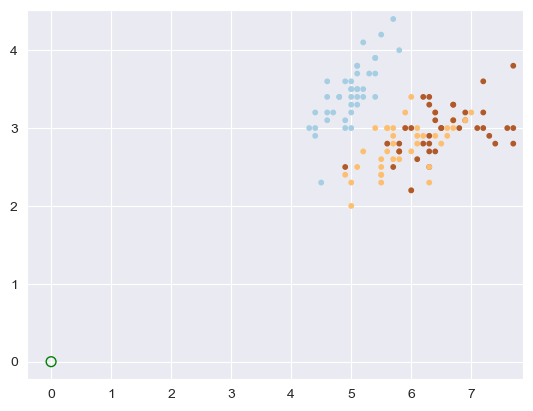

In [87]:
def decision_funct(x, w, b):
    # Calculate the decision value for input x
    return np.dot(arr_phi(X)[:, 2:], w) + b


def visual_kernelSVM(X_train, y_train, w, b, support_vectors):
    # Plot the training data points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 15)
    yy = np.linspace(ylim[0], ylim[1], 10)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = decision_funct(xy, w, b).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(
        XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
    )
    # plot support vectors
    ax.scatter(
        support_vectors[0].astype(int),
        support_vectors[1].astype(int),
        s=50,
        linewidth=1,
        facecolors="none",
        edgecolors="g",
    )

    plt.show()

support_vectors = np.where((lmbda > 0) & (lmbda < C))#[0]
visual_kernelSVM(X_train, y_train, w, b, lmbda)

In [ ]:
# evaluate performance on the testing data
print("Model accuracy:",len(np.where(y_test * decision_funct(X_test, w, b) > 0)[0])/len(X_test))

## 5. Standard SVM implementation **(0.5 pt)**

Find out functionality of the `sklearn` built-in imlementation of the svm algorithm. Run it on the data to compare with your own implementation


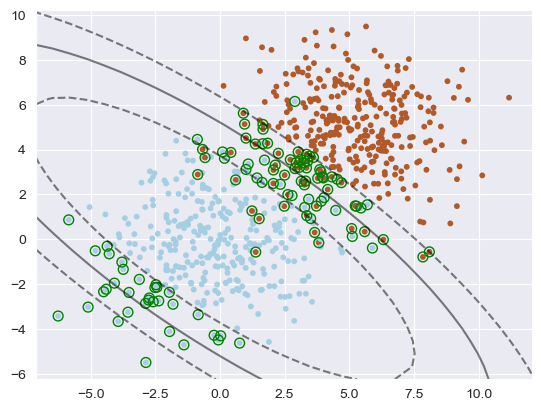

In [37]:
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="poly", degree=2, C=1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=50,
    linewidth=1,
    facecolors="none",
    edgecolors="g",
)
plt.show()

---
#### **Question 5.1 (0.125 pt)**  

>  Find out how to evaluate performance of nonlinear SVM classifier on the test data, and evaluate it.
---

In [38]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


Accuracy: 0.9696969696969697
F1 Score: 0.9673202614379085


---
#### **Question 5.2 (0.375 pt)**  

>  Perform hyperparameter tuning of the standard SKlearn SVM model on IRIS dataset.

Choose at least two kernel functions (e.g., linear, polynomial, radial basis function, or sigmoid) to compare their performance on your dataset.

Perform a grid search to tune the hyperparameters of your SVM classifiers. For each kernel, investigate a range of values for at least the following hyperparameters:

a. Regularization parameter C (for both hard margin and soft margin SVMs)
b. Kernel-specific parameters (e.g., degree for polynomial kernel, gamma for RBF kernel)

Use cross-validation (e.g., k-fold cross-validation) to evaluate the performance of the different configurations. Measure the performance using appropriate evaluation metrics such as accuracy, F1-score, precision, and recall.

Analyze the results and select the best-performing model (i.e., the optimal kernel function and hyperparameter values). Discuss how your chosen model compares to the default settings and the other models you tested.

---

In [39]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Load dataset (replace with your dataset)
data = datasets.load_iris()
X = data.data
y = data.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = [
    {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4],  # applicable for 'poly' kernel
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # applicable for 'rbf', 'poly', 'sigmoid' kernels
        'coef0': [0, 1, 2, 3]  # applicable for 'poly', 'sigmoid' kernels
    }
]

# Initialize the SVM classifier
svm = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Train the best model
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Test the best model
y_pred = best_svm.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Print the classification report
print(classification_report(y_test, y_pred))

Best parameters found: {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Accuracy: 1.0
F1-score: 1.0
Precision: 1.0
Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## 6. Summary **(0.5 pts)**

---



Write a short report about the work you did.

Do not forget to discuss the following points:

*   a general idea of SVM classification;
*   difference between hard and soft margin approach;
*   SVM as an optimization task
*   how Wolfe dual problem allows using execution time of your implementation and sklearn, and reasons for that difference (if any)
*   complexity of the various approaches and algorithms
*   any difficulties you had completing the tasks



---
#### **Question 6.1 (0.5 pts)**  

In the task above, we can clearly see that the hyperparameter tuning job clearly overfitted the data, resulting with absolute as a value of every metric.

In this work, we explored Support Vector Machine (SVM) classification, a robust algorithm for separating data points into distinct classes. SVMs can use either hard margin or soft margin approaches, with the latter allowing for some margin violations.

Formulated as an optimization task, SVM aims to maximize the margin between classes while minimizing classification errors. The Wolfe dual problem offers an efficient way to solve this optimization problem.

Implementing SVMs involves managing complexities such as kernel functions and optimization techniques. One challenge was ensuring compatibility between components like partial derivative calculations and the SMO algorithm.

I had difficulties choosing the right function for the partial derivative, but when I chose the lambda_i formula, after some time I got it working. Also I had problems with visualizing the kernel SVM.

---